In [121]:
import numpy as np
from transformers import GPT2Tokenizer, GPT2Model
from transformers import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# Import the necessary functions
import logging
# Set the logging level to WARNING to suppress INFO messages
logging.basicConfig(level=logging.WARNING)
import transformers

#logging.set_verbosity_error()
# Disable specific warnings
transformers.logging.set_verbosity_error()
from inference_utils import load_model_and_tokenizer, generate_predictions, setup_device
import json #, jsonlines

from transformers import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
import torch

from tqdm import tqdm
import re
import json
import re
from collections import Counter

from sklearn.metrics.pairwise import cosine_similarity

Load the model

In [122]:

#dataset = "/home/s220331/GROK/Thesis/data_MIO_mask_NEW_correct/ID_mask_B_composition.200.20.12.6/"

#"/home/s220331/GROK/Thesis/data/composition_SMALL.200.20.12.6"
#ID_mask_B = "/dtu-compute/s220331/composition/model_paper/mask_B_0_WD_0_3_new/checkpoint-700000/" #"/dtu-compute/s220331/composition/model_paper/correct_ID_mask_B_0_WD_0_03/checkpoint-1500000/"
#model_path = ID_mask_B 
#/scratch/davide/model_paper/outputs_SMALL/checkpoint-1500000/" # model normal on small dataset wuth chosen checkpoints!



dataset = "/home/s220331/GROK/Thesis/data/composition_SMALL.200.20.12.6/"
#="/home/s220331/GROK/Thesis/data/composition.2000.200.12.6/"  #"/dtu-compute/s220331/composition/outputs_BIG_new/checkpoint-1500000/"
#model_path = "/scratch/davide/model_paper/outputs_SMALL/checkpoint-1500000/" # model normal on small dataset wuth chosen checkpoints!
model_path = "/scratch/davide/model_paper/outputs_SMALL/checkpoint-2000/" # model normal on small dataset wuth chosen checkpoints!
file_path_atomic= dataset+"train.json"

#dataset = "/home/s220331/GROK/Thesis/data/composition_SMALL.200.20.12.6"
#model_path = "/scratch/davide/model_paper/outputs_SMALL/checkpoint-1500000/" # model normal on small dataset wuth chosen checkpoints!

# MOdle set up do not change anything here below
# model set up
#device = torch.device('cuda:5')
device = setup_device()
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
word_embedding = model.lm_head.weight.data
tokenizer = GPT2Tokenizer.from_pretrained(model_path, output_hidden_states=True)
tokenizer.padding_side = "left" 
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
model.config.pad_token_id = model.config.eos_token_id


# A_Experiment (ID/OOD are interchangable)
In this section we want to show that a bridege entity "b" found in layer 5 , do not change accordingly if is part of an OOD or ID atomic compositio

In [123]:

# extract all the data and divide in ID and OOD atomics
# set data
#file_path_atomic= "/home/s220331/GROK/Thesis/data/composition.2000.200.12.6/train.json"

all_atomic = set()     # (h,r,t)
atomic_dict = dict()   # (h,r) -> t
with open(file_path_atomic) as f:  # from the correct data or data_MIO !!!
    train_items = json.load(f)
for item in tqdm(train_items):
    temp = item['target_text'].strip("><").split("><")
    if len(temp) != 4:
        continue
    if temp[0] == "mask":
        print("mask11111111")
        continue

    h,r,t = temp[:3]
    #print(h,r,t)
    atomic_dict[(h,r)] = t
    all_atomic.add((h,r,t))
print("# all_atomic:", len(all_atomic))

id_atomic = set()
for item in tqdm(train_items):
    temp = item['target_text'].strip("><").split("><")
    if len(temp) == 4:
        continue
    if temp[0] == "mask":
        #print("mask")
        continue
    h, r1, r2, t = temp[:4]
    if (h, r1) in atomic_dict:
        b = atomic_dict[(h, r1)]
    else:
        #print(f"Key {(h, r1)} not found in atomic_dict")
    # Handle the case where the key is missing (e.g., skip or assign a default value)
        continue  # or set b = some_default_value
    assert atomic_dict[(b, r2)] == t
    id_atomic.add((h,r1,b))
    id_atomic.add((b,r2,t))

ood_atomic = all_atomic - id_atomic
print("# id_atomic, # ood_atomic:", len(id_atomic), len(ood_atomic))



  0%|          | 0/51880 [00:00<?, ?it/s]

100%|██████████| 51880/51880 [00:00<00:00, 1346796.05it/s]


# all_atomic: 4000


100%|██████████| 51880/51880 [00:00<00:00, 528383.53it/s]

# id_atomic, # ood_atomic: 3800 200


In [124]:
id_atomic

{('e_45', 'r_7', 'e_188'),
 ('e_108', 'r_0', 'e_154'),
 ('e_132', 'r_5', 'e_130'),
 ('e_128', 'r_5', 'e_47'),
 ('e_59', 'r_17', 'e_138'),
 ('e_116', 'r_6', 'e_35'),
 ('e_98', 'r_18', 'e_143'),
 ('e_32', 'r_3', 'e_48'),
 ('e_61', 'r_19', 'e_169'),
 ('e_76', 'r_9', 'e_52'),
 ('e_5', 'r_1', 'e_23'),
 ('e_154', 'r_9', 'e_64'),
 ('e_182', 'r_14', 'e_42'),
 ('e_147', 'r_3', 'e_46'),
 ('e_46', 'r_1', 'e_161'),
 ('e_195', 'r_1', 'e_105'),
 ('e_102', 'r_19', 'e_65'),
 ('e_74', 'r_15', 'e_61'),
 ('e_135', 'r_0', 'e_142'),
 ('e_30', 'r_8', 'e_46'),
 ('e_68', 'r_19', 'e_8'),
 ('e_136', 'r_13', 'e_55'),
 ('e_84', 'r_4', 'e_83'),
 ('e_32', 'r_1', 'e_90'),
 ('e_121', 'r_0', 'e_153'),
 ('e_111', 'r_12', 'e_40'),
 ('e_60', 'r_8', 'e_117'),
 ('e_148', 'r_0', 'e_153'),
 ('e_106', 'r_11', 'e_26'),
 ('e_9', 'r_11', 'e_148'),
 ('e_75', 'r_11', 'e_178'),
 ('e_128', 'r_17', 'e_25'),
 ('e_37', 'r_0', 'e_133'),
 ('e_35', 'r_0', 'e_168'),
 ('e_133', 'r_8', 'e_159'),
 ('e_190', 'r_11', 'e_65'),
 ('e_137', 'r_18',

In [125]:
#  extract the most common entity found in OOD atomic (as are such a small number then id atomics)

# Extract all final entities (third element in each tuple)
final_entities = [t for _, _, t in ood_atomic]

# Count the occurrences of each final entity
entity_counter = Counter(final_entities)

most_common_entities = entity_counter.most_common(6)

# Output the results
print("✅ Top 6 most common final entities:")
for entity, frequency in most_common_entities:
    print(f"  {entity}: found {frequency} times in OOD")


✅ Top 6 most common final entities:
  e_161: found 4 times in OOD
  e_41: found 4 times in OOD
  e_126: found 4 times in OOD
  e_150: found 4 times in OOD
  e_180: found 3 times in OOD
  e_184: found 3 times in OOD


In [126]:
most_common_entities_list = [] # is meant the most common entity found as 1-hop OOD
for entity, _ in most_common_entities:
    most_common_entities_list.append(f"<{entity}>")

# Output the result
print("most_common_entities =", most_common_entities_list)

most_common_entities = ['<e_161>', '<e_41>', '<e_126>', '<e_150>', '<e_180>', '<e_184>']


## NOt used

In [127]:
#file_path_atomic= "/home/s220331/GROK/Thesis/data/composition.2000.200.12.6/train.json"

# here we chose which entity is most seen as end of 1-hop relation
# Load the JSON data
with open(file_path_atomic, 'r') as file:
    data = json.load(file)

# Regex pattern to extract all <e_x> entities
entity_pattern = re.compile(r'<e_(\d+)></a>')

# Step 1: Extract entities in the range 0-1900
entities = []
for entry in data:
    target_text = entry.get("target_text", "").strip()
    entity_matches = entity_pattern.findall(target_text)
    # Filter entities with x between 0 and 1900
    entities.extend([f"<e_{x}>" for x in entity_matches if 0 <= int(x) <= 1999])

# Step 2: Find the most frequent entity
entity_counter = Counter(entities)
most_common_entity, frequency = entity_counter.most_common(1)[0]
top_common_entities = entity_counter.most_common(10)
#print("Top 10 most common entities (entity, frequency):")
#for entity, freq in top_common_entities:
#   print(f"  {entity}: {freq}")

print(f"✅ Most frequent entity: {most_common_entity} (found {frequency} times)")



✅ Most frequent entity: <e_7> (found 447 times)


# continue here

In [128]:
#file_path_atomic= "/home/s220331/GROK/Thesis/data/composition.2000.200.12.6/train.json"

# here we chose which entity is most seen as end of 1-hop relation
# Load the JSON data
#with open(file_path_atomic, 'r') as file:
    #data = json.load(file)
#
# chosen most common entity to use
import re

def is_valid_atomic(text):
    """
    Returns True if text exactly follows the pattern:
    <e_x><r_y><e_z></a>
    (i.e. three tokens: entity, relation, entity)
    """
    text_1 = text.strip()
    # Must end with the closing tag
    if text_1.startswith('<mask>') or not text_1.endswith('</a>'):
        return False
    # Remove the trailing '</a>' to analyze the tokens
    main_text = text[:-4]
    # Extract tokens of the form <e_...> or <r_...>
    tokens = re.findall(r'<(e_\d+|r_\d+)>', main_text)
    # We require exactly 3 tokens
    if len(tokens) != 3:
        return False
    # And the expected order: entity, relation, entity
    if tokens[0].startswith('e_') and tokens[1].startswith('r_') and tokens[2].startswith('e_'):
        return True
    return False

def atomic_b(most_common_entity, train_items=train_items):

    # Step 3: Extract entries into atomic_b containing the most frequent entity
    atomic_b = [entry["target_text"]
    for entry in train_items
       if entry.get("target_text", "").strip().endswith(most_common_entity + "</a>")
     and is_valid_atomic(entry.get("target_text", ""))]

    print(f"✅ Number of entries with valid atomic pattern ending in {most_common_entity} both :ID and OOD are: {len(atomic_b)}")
    print("🔎 Sample entries:", atomic_b[:])
    #pattern = re.compile(r'(<e_\d+><r_\d+></a>)')

    # Extract the first entity-relation pair from each entry
    #atomic_b_pairs = [pattern.search(entry).group(1) for entry in atomic_b if pattern.search(entry)]
        # ✅ Updated regex pattern to match only <e_x><r_y><e_z></a>
    #pattern = re.compile(r'(<e_\d+><r_\d+><e_\d+></a>)')

    # Extract matching pairs only if the pattern is found
    #atomic_b_pairs = [pattern.search(entry).group(1) for entry in atomic_b if pattern.search(entry)]
    atomic_b_pairs = [entry for entry in atomic_b if is_valid_atomic(entry)]


    return atomic_b_pairs 
    # Output results
    #print(f"✅ Extracted entity-relation pairs: {atomic_b_pairs[:5]}")

In [129]:
atomic_b("<e_44>")

✅ Number of entries with valid atomic pattern ending in <e_44> both :ID and OOD are: 13
🔎 Sample entries: ['<e_25><r_15><e_44></a>', '<e_61><r_14><e_44></a>', '<e_70><r_4><e_44></a>', '<e_160><r_1><e_44></a>', '<e_5><r_2><e_44></a>', '<e_100><r_18><e_44></a>', '<e_155><r_16><e_44></a>', '<e_195><r_8><e_44></a>', '<e_35><r_6><e_44></a>', '<e_15><r_3><e_44></a>', '<e_188><r_8><e_44></a>', '<e_155><r_9><e_44></a>', '<e_14><r_5><e_44></a>']


['<e_25><r_15><e_44></a>',
 '<e_61><r_14><e_44></a>',
 '<e_70><r_4><e_44></a>',
 '<e_160><r_1><e_44></a>',
 '<e_5><r_2><e_44></a>',
 '<e_100><r_18><e_44></a>',
 '<e_155><r_16><e_44></a>',
 '<e_195><r_8><e_44></a>',
 '<e_35><r_6><e_44></a>',
 '<e_15><r_3><e_44></a>',
 '<e_188><r_8><e_44></a>',
 '<e_155><r_9><e_44></a>',
 '<e_14><r_5><e_44></a>']

list_atomic_b=[]
chosen_entity= ["<e_877>"]
for i in chosen_entity: #most_common_entities:
    list_atomic_b.append(atomic_b(i))

print("done")


In [130]:
most_common_entities_list

['<e_161>', '<e_41>', '<e_126>', '<e_150>', '<e_180>', '<e_184>']

In [131]:
# a list containing (6) in different lists the atomic_b (only entity,relation)for each most common entity
list_atomic_b_most_common=[]
# for i in the 6 most common entries
for i in most_common_entities_list:
    list_atomic_b_most_common.append(atomic_b(i))
print("len(list_atomic_b_most_common)=", len(list_atomic_b_most_common)) 
print("done")

✅ Number of entries with valid atomic pattern ending in <e_161> both :ID and OOD are: 26
🔎 Sample entries: ['<e_28><r_3><e_161></a>', '<e_131><r_5><e_161></a>', '<e_135><r_5><e_161></a>', '<e_166><r_11><e_161></a>', '<e_28><r_9><e_161></a>', '<e_36><r_17><e_161></a>', '<e_150><r_9><e_161></a>', '<e_173><r_7><e_161></a>', '<e_116><r_4><e_161></a>', '<e_111><r_0><e_161></a>', '<e_110><r_12><e_161></a>', '<e_46><r_1><e_161></a>', '<e_20><r_15><e_161></a>', '<e_193><r_7><e_161></a>', '<e_156><r_2><e_161></a>', '<e_24><r_7><e_161></a>', '<e_83><r_3><e_161></a>', '<e_165><r_18><e_161></a>', '<e_9><r_17><e_161></a>', '<e_163><r_19><e_161></a>', '<e_179><r_18><e_161></a>', '<e_89><r_8><e_161></a>', '<e_177><r_14><e_161></a>', '<e_36><r_13><e_161></a>', '<e_141><r_4><e_161></a>', '<e_118><r_9><e_161></a>']
✅ Number of entries with valid atomic pattern ending in <e_41> both :ID and OOD are: 22
🔎 Sample entries: ['<e_35><r_16><e_41></a>', '<e_196><r_4><e_41></a>', '<e_119><r_5><e_41></a>', '<e_19

In [132]:
list_atomic_b_most_common[0]

['<e_28><r_3><e_161></a>',
 '<e_131><r_5><e_161></a>',
 '<e_135><r_5><e_161></a>',
 '<e_166><r_11><e_161></a>',
 '<e_28><r_9><e_161></a>',
 '<e_36><r_17><e_161></a>',
 '<e_150><r_9><e_161></a>',
 '<e_173><r_7><e_161></a>',
 '<e_116><r_4><e_161></a>',
 '<e_111><r_0><e_161></a>',
 '<e_110><r_12><e_161></a>',
 '<e_46><r_1><e_161></a>',
 '<e_20><r_15><e_161></a>',
 '<e_193><r_7><e_161></a>',
 '<e_156><r_2><e_161></a>',
 '<e_24><r_7><e_161></a>',
 '<e_83><r_3><e_161></a>',
 '<e_165><r_18><e_161></a>',
 '<e_9><r_17><e_161></a>',
 '<e_163><r_19><e_161></a>',
 '<e_179><r_18><e_161></a>',
 '<e_89><r_8><e_161></a>',
 '<e_177><r_14><e_161></a>',
 '<e_36><r_13><e_161></a>',
 '<e_141><r_4><e_161></a>',
 '<e_118><r_9><e_161></a>']

In [133]:
# Create lookup sets for faster matching (containing just the first and second elements of the tuples)
id_pairs = {(e, r) for e, r, _ in id_atomic}
ood_pairs = {(e, r) for e, r, _ in ood_atomic}

list_b_ID = []
list_b_OOD = []

# Extract all the data for each entry and divide in ID and OOD atomics
for i in list_atomic_b_most_common:
    string_list = i
    #print("string_list:", i)

    # Initialize result lists
    b_ID = []
    b_OOD = []


    # Function to categorize and store strings
    for s in string_list:
        #print("s:", s)
        #extract the entry for classification
        #for j in s:
        match = re.findall(r'<(e_\d+)><(r_\d+)>', s)
        if match:
               
            pair = match[0]

            #if the pair(h,r) is in the id_atomic then it is ID atomic
            if pair in id_pairs:
                        
                #print("pair:", pair)
                 # Convert the tuple to the desired string format
                pair_atomic = f"<{pair[0]}><{pair[1]}>"
                b_ID.append(pair_atomic)
                #print("pair:",pair ) 
                
            elif pair in ood_pairs:
                #print("pair:", pair)
                pair_atomic = f"<{pair[0]}><{pair[1]}>"
                b_OOD.append(pair_atomic)
            else:
                print("error matching")
    print("b_ID, b_OOD:", len(b_ID), len(b_OOD))
    list_b_ID.append(b_ID)
    list_b_OOD.append(b_OOD)
    print("done. Now we know which of the atomic_b are ID and OOD")

b_ID, b_OOD: 22 4
done. Now we know which of the atomic_b are ID and OOD
b_ID, b_OOD: 18 4
done. Now we know which of the atomic_b are ID and OOD
b_ID, b_OOD: 15 4
done. Now we know which of the atomic_b are ID and OOD
b_ID, b_OOD: 12 4
done. Now we know which of the atomic_b are ID and OOD
b_ID, b_OOD: 21 3
done. Now we know which of the atomic_b are ID and OOD
b_ID, b_OOD: 19 3
done. Now we know which of the atomic_b are ID and OOD


In [134]:
#print(list_b_ID[1])
print(list_b_OOD[0])

['<e_177><r_14>', '<e_36><r_13>', '<e_141><r_4>', '<e_118><r_9>']


In [135]:
def return_rank(hd, word_embedding_, token, metric='dot', token_list=None):
    """
hd: Hidden states or output from a neural network.
word_embedding_: Embedding matrix for words. (matrix that convert words to their embedding representation)
token: The specific token (word) for which we want to find the rank.
metric: The similarity metric to use ('dot' for dot product, 'cos' for cosine similarity).
token_list: Optional list of tokens to consider for ranking."""

    if metric == 'dot':
        word_embedding = word_embedding_
    elif metric == 'cos':
        word_embedding = F.normalize(word_embedding_, p=2, dim=1)
    else:
        assert False
    #Compute the similarity scores (logits) between the hidden states (hd) and the word embeddings using matrix multiplication.
    logits_ = torch.matmul(hd, word_embedding.T)  # a vlaue higher if he similarity with the analyzed "word" is higehr

    rank = [] 
    for j in range(len(logits_)):
        log = logits_[j].cpu().numpy()
        if token_list is None:
            temp = [[i, log[i]] for i in range(len(log))]
        else:
            temp = [[i, log[i]] for i in token_list]
        temp.sort(key=lambda var: var[1], reverse=True)
        rank.append([var[0] for var in temp].index(token))
    return rank


  <e_1585>: 479
  <e_816>: 473
  <e_1948>: 461
  <e_17>: 446
  <e_677>: 444
  <e_1542>: 438
  <e_1564>: 438
  <e_1337>: 437
  <e_1322>: 437
  <e_1566>: 435

In [136]:
most_common_entities_list

['<e_161>', '<e_41>', '<e_126>', '<e_150>', '<e_180>', '<e_184>']

In [137]:
list_b_ID

[['<e_28><r_3>',
  '<e_131><r_5>',
  '<e_135><r_5>',
  '<e_166><r_11>',
  '<e_28><r_9>',
  '<e_36><r_17>',
  '<e_150><r_9>',
  '<e_173><r_7>',
  '<e_116><r_4>',
  '<e_111><r_0>',
  '<e_110><r_12>',
  '<e_46><r_1>',
  '<e_20><r_15>',
  '<e_193><r_7>',
  '<e_156><r_2>',
  '<e_24><r_7>',
  '<e_83><r_3>',
  '<e_165><r_18>',
  '<e_9><r_17>',
  '<e_163><r_19>',
  '<e_179><r_18>',
  '<e_89><r_8>'],
 ['<e_35><r_16>',
  '<e_196><r_4>',
  '<e_119><r_5>',
  '<e_19><r_17>',
  '<e_48><r_3>',
  '<e_172><r_9>',
  '<e_88><r_0>',
  '<e_192><r_2>',
  '<e_105><r_11>',
  '<e_87><r_9>',
  '<e_11><r_18>',
  '<e_182><r_15>',
  '<e_51><r_19>',
  '<e_96><r_3>',
  '<e_65><r_19>',
  '<e_91><r_3>',
  '<e_60><r_19>',
  '<e_197><r_6>'],
 ['<e_70><r_1>',
  '<e_195><r_6>',
  '<e_119><r_15>',
  '<e_93><r_11>',
  '<e_152><r_15>',
  '<e_71><r_18>',
  '<e_44><r_3>',
  '<e_128><r_0>',
  '<e_161><r_2>',
  '<e_156><r_11>',
  '<e_126><r_10>',
  '<e_76><r_13>',
  '<e_93><r_18>',
  '<e_158><r_11>',
  '<e_26><r_11>'],
 ['<e_186

In [138]:
most_common_entities_list

['<e_161>', '<e_41>', '<e_126>', '<e_150>', '<e_180>', '<e_184>']

In [139]:
# Create a sample array
#b= #"e_440"
most_common_entities_list # most_common_entities = ['<e_877>', '<e_440>', '<e_99>', '<e_1133>', '<e_40>', '<e_135>']
rank_list_ood = []
rank_list_id = []
#input_ID =  list_b_ID[0] 

#input_OOD = list_b_OOD[0]


# Store representations on the first and last layers
#first_layer_reps = []
#last_layer_reps = []
ID_rep_list = []
OOD_rep_list = []
target_layer = 6   # we are extarcting b from layer 5
count=0
for  input_ID in list_b_ID:
    # process all ID atomics which get to the same bridege "b"
    ID_rep = []
    b_id = most_common_entities_list[count]
    if count >0:
        break
    print("B_id",b_id)
    for text in input_ID:
        
        # Tokenize input
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"]
    
        # Forward pass
        with torch.no_grad():
       # here the same model but with different input !! 
           outputs = model(
           input_ids=input_ids,
           output_hidden_states=True
        )
        # Extract hidden states
        hidden_states = outputs.hidden_states
        #print( hidden_states)
        token_position = 1  # 'B' is at position 1 in each input
        ID_rep.append(hidden_states[target_layer][0, token_position].tolist())

        rank_id = return_rank(hidden_states[target_layer][0, :, :], word_embedding, tokenizer(b_id)['input_ids'][0])[-1]
        rank_list_id.append(rank_id)
    ID_rep_list.append(ID_rep) 
    count+=1

count_ood=0
for input_OOD in list_b_OOD:
   #for OOD case
    OOD_rep=[]
    b_ood = most_common_entities_list[count_ood]
    
    if count_ood >0:
        break
    print("B_ood",b_ood)
    for text in input_OOD:
        
        # Tokenize input
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"]
    
        # Forward pass
        with torch.no_grad():
        # here the same model but with different input !! 
           outputs = model(
           input_ids=input_ids,
           output_hidden_states=True
        )
        # Extract hidden states
        hidden_states = outputs.hidden_states
        #print( hidden_states)
        token_position = 1  # 'B' is at position 1 in each input
        OOD_rep.append(hidden_states[target_layer][0, token_position].tolist())


        # check that b is extracted actuallly
        rank = return_rank(hidden_states[target_layer][0, :, :], word_embedding, tokenizer(b_ood)['input_ids'][0])[-1]
        rank_list_ood.append(rank)
    OOD_rep_list.append(OOD_rep)
    count_ood+=1



B_id <e_161>


B_ood <e_161>


In [140]:
rank_list_id 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [141]:
rank_list_ood

[15, 0, 2, 5]

In [142]:
most_common_entities_list 

['<e_161>', '<e_41>', '<e_126>', '<e_150>', '<e_180>', '<e_184>']

In [143]:
# Create a sample array
#b= "e_440"
most_common_entities_list # most_common_entities = ['<e_440>', '<e_877>', '<e_40>', '<e_135>', '<e_99>', '<e_1133>']
rank_list = []
rank_list_id = []
#input_ID =  list_b_ID[0] 

#input_OOD = list_b_OOD[0]


# Store representations on the first and last layers
#first_layer_reps = []
#last_layer_reps = []
ID_rep_list = []
OOD_rep_list = []
target_layer = 5   # we are extarcting b from layer 5
count=0
for  input_ID in list_b_ID:
    # process all ID atomics which get to the same bridege "b"
    ID_rep = []
    b_id = most_common_entities_list[count]
    for text in input_ID:
        
        # Tokenize input
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"]
    
        # Forward pass
        with torch.no_grad():
       # here the same model but with different input !! 
           outputs = model(
           input_ids=input_ids,
           output_hidden_states=True
        )
        # Extract hidden states
        hidden_states = outputs.hidden_states
        #print( hidden_states)
        token_position = 1  # 'B' is at position 1 in each input
        ID_rep.append(hidden_states[target_layer][0, token_position].tolist())

        rank_id = return_rank(hidden_states[target_layer][0, :, :], word_embedding, tokenizer(b_id)['input_ids'][0])[-1]
        rank_list_id.append(rank_id)
    ID_rep_list.append(ID_rep) 
    count+=1

count_ood=0
for input_OOD in list_b_OOD:
   #for OOD case
    OOD_rep=[]
    b_ood = most_common_entities_list[count_ood]
    for text in input_OOD:
        
        # Tokenize input
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"]
    
        # Forward pass
        with torch.no_grad():
        # here the same model but with different input !! 
           outputs = model(
           input_ids=input_ids,
           output_hidden_states=True
        )
        # Extract hidden states
        hidden_states = outputs.hidden_states
        #print( hidden_states)
        token_position = 1  # 'B' is at position 1 in each input
        OOD_rep.append(hidden_states[target_layer][0, token_position].tolist())


        # check that b is extracted actuallly
        rank = return_rank(hidden_states[target_layer][0, :, :], word_embedding, tokenizer(b_ood)['input_ids'][0])[-1]
        rank_list.append(rank)
    OOD_rep_list.append(OOD_rep)
    count_ood+=1



In [144]:
rank_list

[22, 0, 3, 11, 1, 7, 33, 1, 14, 20, 19, 27, 3, 4, 0, 8, 1, 37, 0, 2, 0, 12]

In [145]:
rank_list_id

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [146]:
len(ID_rep_list), len(OOD_rep_list)


(6, 6)

# 1 solo entity

Plotting:

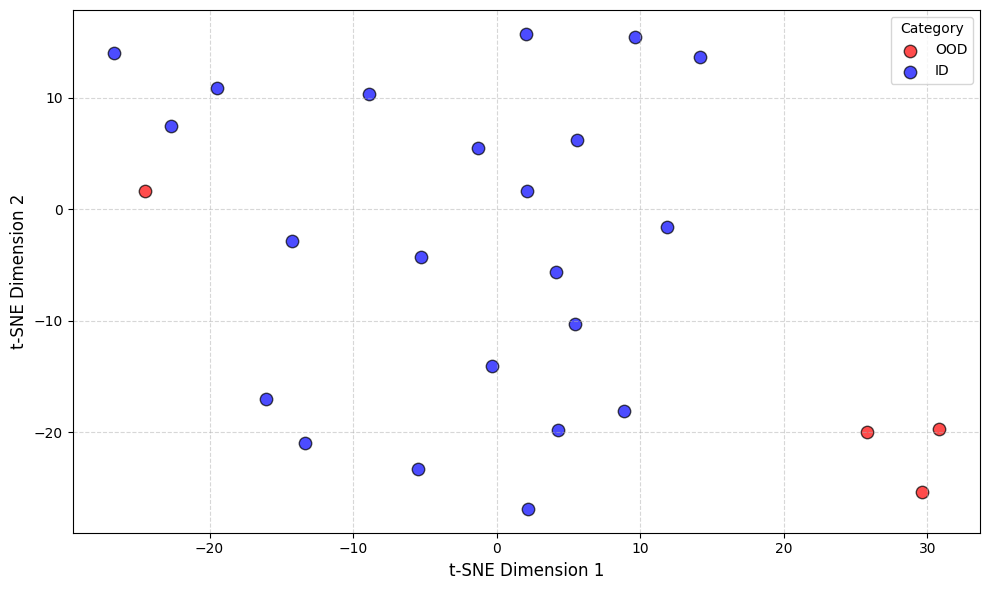

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Sample inputs (replace these with your actual data)
all_representations = np.vstack([ID_rep_list[0], OOD_rep_list[0]])  # Your data
labels = ["b_ID" for _ in ID_rep_list[0]] + ["b_OOD" for _ in OOD_rep_list[0]]

# Parameters
perplexity = 7  # For ~400 samples, perplexity between 20-50 works well
n_components = 2  # 2D visualization is standard

# Perform t-SNE
tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
reduced_embeddings = tsne.fit_transform(all_representations)

# Color map: one color for 'b_ID', another for 'b_OOD'
color_map = {"b_ID": "blue", "b_OOD": "red"}
label_map = {"b_ID": "ID", "b_OOD": "OOD"}  # For cleaner legend

# Plot the results
plt.figure(figsize=(10, 6))
for label in set(labels):
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        reduced_embeddings[indices, 0],
        reduced_embeddings[indices, 1],
        c=color_map[label],
        label=label_map[label],
        alpha=0.7,
        edgecolors='k',
        s=80
    )

#plt.title("t-SNE Visualization of Token Representations", fontsize=14)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend(title="Category", loc="upper right")  # Legend now inside the plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [148]:
len(OOD_rep_list[0])

4

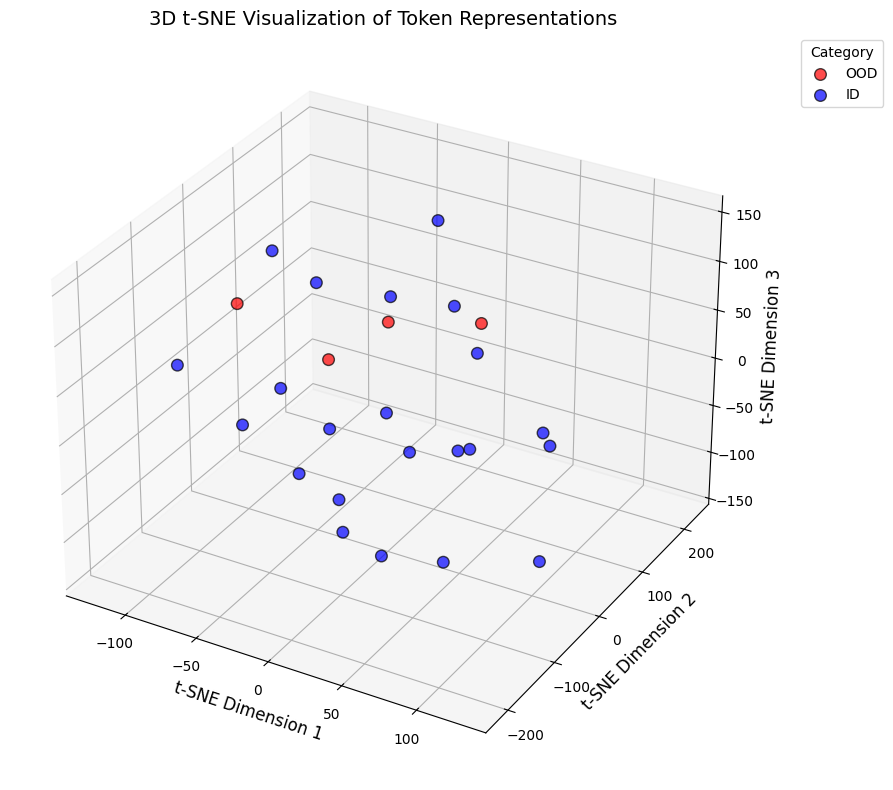

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Sample inputs (replace with your actual data)
# all_representations = np.vstack([ID_rep, OOD_rep])  # Your embeddings
# labels = ["b_ID" for _ in input_ID] + ["b_OOD" for _ in input_OOD]

# Parameters
perplexity = 5  # Adjust between 20-50 for ~400 samples
n_components = 3  # For 3D visualization

# Perform t-SNE
tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
reduced_embeddings = tsne.fit_transform(all_representations)

# Color map: one color for 'b_ID', another for 'b_OOD'
color_map = {"b_ID": "blue", "b_OOD": "red"}
label_map = {"b_ID": "ID", "b_OOD": "OOD"}  # Cleaner legend names

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each category with its respective color
for label in set(labels):
    indices = [i for i, l in enumerate(labels) if l == label]
    ax.scatter(
        reduced_embeddings[indices, 0],
        reduced_embeddings[indices, 1],
        reduced_embeddings[indices, 2],
        c=color_map[label],
        label=label_map[label],
        alpha=0.7,
        edgecolors='k',
        s=70
    )

# Plot aesthetics
ax.set_title("3D t-SNE Visualization of Token Representations", fontsize=14)
ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
ax.set_zlabel("t-SNE Dimension 3", fontsize=12)
ax.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### e404m

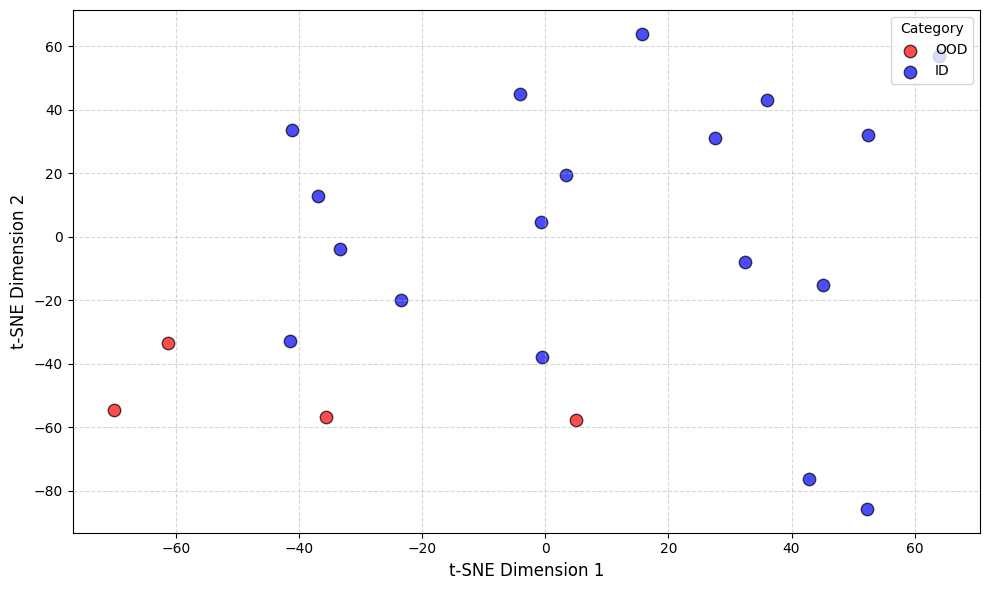

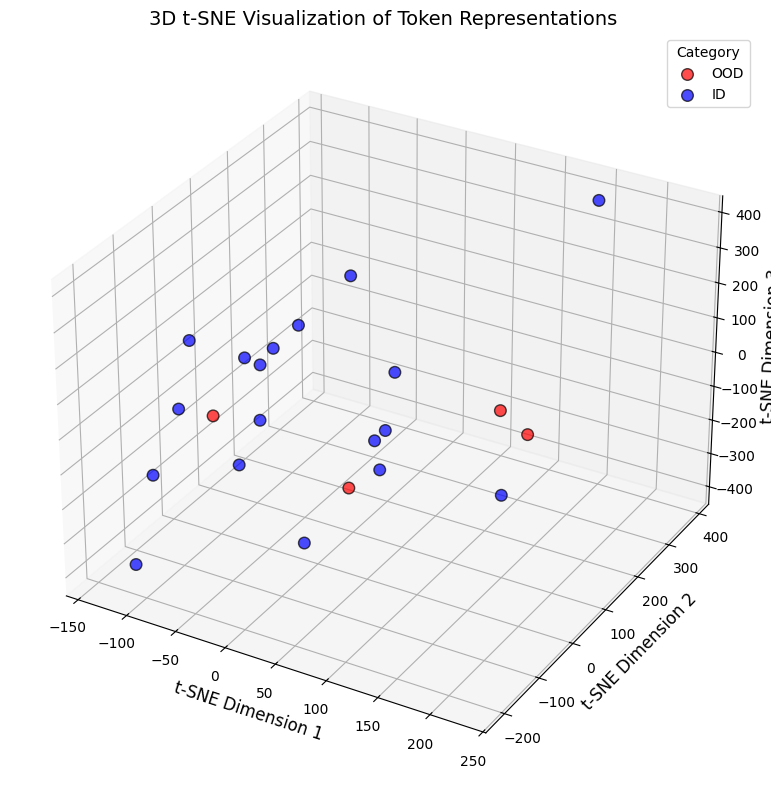

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Sample inputs (replace these with your actual data)
all_representations = np.vstack([ID_rep_list[1], OOD_rep_list[1]])  # Your data
labels = ["b_ID" for _ in ID_rep_list[1]] + ["b_OOD" for _ in OOD_rep_list[1]]

# Parameters
perplexity = 5  # For ~400 samples, perplexity between 20-50 works well
n_components = 2  # 2D visualization is standard

# Perform t-SNE
tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
reduced_embeddings = tsne.fit_transform(all_representations)

# Color map: one color for 'b_ID', another for 'b_OOD'
color_map = {"b_ID": "blue", "b_OOD": "red"}
label_map = {"b_ID": "ID", "b_OOD": "OOD"}  # For cleaner legend

# Plot the results
plt.figure(figsize=(10, 6))
for label in set(labels):
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        reduced_embeddings[indices, 0],
        reduced_embeddings[indices, 1],
        c=color_map[label],
        label=label_map[label],
        alpha=0.7,
        edgecolors='k',
        s=80
    )

#plt.title("t-SNE Visualization of Token Representations", fontsize=14)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend(title="Category", loc="upper right")  # Legend now inside the plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Sample inputs (replace with your actual data)
# all_representations = np.vstack([ID_rep, OOD_rep])  # Your embeddings
# labels = ["b_ID" for _ in input_ID] + ["b_OOD" for _ in input_OOD]

# Parameters
perplexity = 5 # Adjust between 20-50 for ~400 samples
n_components = 3  # For 3D visualization

# Perform t-SNE
tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
reduced_embeddings = tsne.fit_transform(all_representations)

# Color map: one color for 'b_ID', another for 'b_OOD'
color_map = {"b_ID": "blue", "b_OOD": "red"}
label_map = {"b_ID": "ID", "b_OOD": "OOD"}  # Cleaner legend names

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each category with its respective color
for label in set(labels):
    indices = [i for i, l in enumerate(labels) if l == label]
    ax.scatter(
        reduced_embeddings[indices, 0],
        reduced_embeddings[indices, 1],
        reduced_embeddings[indices, 2],
        c=color_map[label],
        label=label_map[label],
        alpha=0.7,
        edgecolors='k',
        s=70
    )

# Plot aesthetics
ax.set_title("3D t-SNE Visualization of Token Representations", fontsize=14)
ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
ax.set_zlabel("t-SNE Dimension 3", fontsize=12)
plt.legend(title="Category", loc="upper right")  # Legend now inside the plot
plt.tight_layout()
plt.show()


# more entitiresm

In [151]:
entity_names = [s.strip("<>") for s in most_common_entities_list]
entity_names

['e_161', 'e_41', 'e_126', 'e_150', 'e_180', 'e_184']

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

def plot_tsne_entities_with_intensity_2d(
    ID_rep_list,
    OOD_rep_list,
    entity_names=entity_names,
    n_entities_to_plot=6,
    perplexity=30,          # For 2D plots with limited samples, lower perplexity is often better
    n_components=2,
    figsize=(10, 8),
):
    """
    Plots a 2D t-SNE visualization of entity embeddings with intensity-based color differences for ID and OOD.
    
    Parameters:
      - ID_rep_list: list of arrays, embeddings for ID entities.
      - OOD_rep_list: list of arrays, embeddings for OOD entities.
      - all_entity_names: list of strings, names of all entities.
      - n_entities_to_plot: int, number of entities to plot.
      - perplexity: int, t-SNE perplexity parameter.
      - n_components: int, number of dimensions for t-SNE (2 for 2D plot).
      - figsize: tuple, size of the figure.
    """
    
    # -------------------------
    # Step 1: Prepare Data
    # -------------------------
    entity_names_chose = entity_names[:n_entities_to_plot]
    ID_rep_list_subset = ID_rep_list[:n_entities_to_plot]
    OOD_rep_list_subset = OOD_rep_list[:n_entities_to_plot]
    
    # Concatenate representations (ID + OOD)
    all_representations = np.vstack(ID_rep_list_subset + OOD_rep_list_subset)
    
    # Create labels for ID and OOD embeddings
    labels = (
        [f"{entity}_ID" for entity in entity_names_chose for _ in range(len(ID_rep_list_subset[entity_names_chose.index(entity)]))]
        + [f"{entity}_OOD" for entity in entity_names_chose for _ in range(len(OOD_rep_list_subset[entity_names_chose.index(entity)]))]
    )
    
    print(f"✅ Total number of samples: {all_representations.shape[0]}")
    
    # -------------------------
    # Step 2: Perform t-SNE
    # -------------------------
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        learning_rate=200,
        early_exaggeration=12,
        n_iter=1000,
        random_state=42
    )
    reduced_embeddings = tsne.fit_transform(all_representations)
    
    # -------------------------
    # Step 3: Color Mapping with Intensity
    # -------------------------
    base_colors = list(mcolors.TABLEAU_COLORS.values())  # Use a list of distinguishable base colors
    entity_color_map = {entity: base_colors[i % len(base_colors)] for i, entity in enumerate(entity_names)}
    
    def adjust_color_intensity(base_color, intensity_factor):
        """Adjusts the intensity of a given base color."""
        rgb = mcolors.to_rgb(base_color)
        return tuple(min(1, c * intensity_factor) for c in rgb)
    
    # Define intensity multipliers: ID gets a higher (lighter) intensity, OOD a lower (darker) one.
    intensity_map = {"ID": 1.5, "OOD": 0.6}
    markers = {"ID": "o", "OOD": "s"}  # Circles for ID, squares for OOD
    
    # -------------------------
    # Step 4: Plotting in 2D
    # -------------------------
    fig, ax = plt.subplots(figsize=figsize)
    
    for entity in entity_names:
        for data_type in ["ID", "OOD"]:
            # Find indices in the overall labels list corresponding to the current entity and type
            indices = [i for i, label in enumerate(labels) if label == f"{entity}_{data_type}"]
            if indices:
                base_color = entity_color_map[entity]
                adjusted_color = adjust_color_intensity(base_color, intensity_map[data_type])
                
                ax.scatter(
                    reduced_embeddings[indices, 0],
                    reduced_embeddings[indices, 1],
                    c=[adjusted_color],
                    marker=markers[data_type],
                    label=f"{entity} ({data_type})",
                    alpha=0.8,
                    edgecolors='k',
                    s=80
                )
    
    # -------------------------
    # Step 5: Plot Aesthetics
    # -------------------------
    ax.set_title("2D t-SNE Visualization of Entities (ID vs OOD with Color Intensity)", fontsize=16)
    ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
    ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
    ax.legend(title="Entity (Type)", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()


✅ Total number of samples: 129


/home/s220331/.conda/envs/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


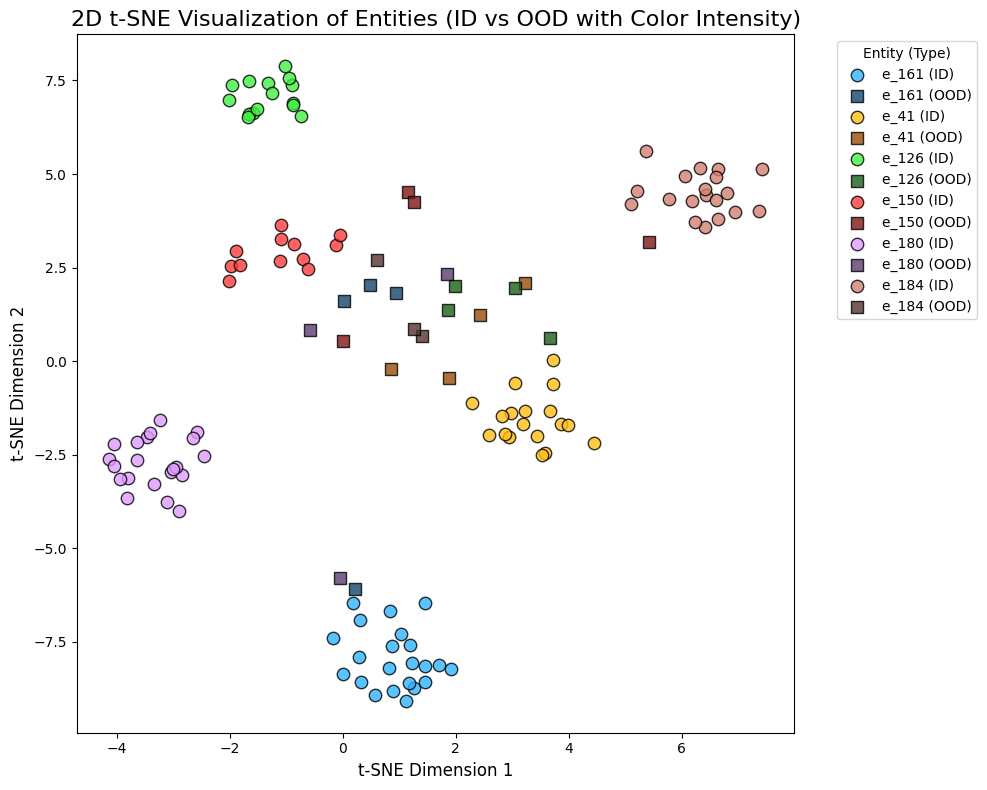

In [153]:
plot_tsne_entities_with_intensity_2d(ID_rep_list, OOD_rep_list, entity_names, n_entities_to_plot=6,perplexity=30)

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # Ensures 3D plotting support
import matplotlib.colors as mcolors

def plot_tsne_entities_with_intensity_3d(
    ID_rep_list,
    OOD_rep_list,
    entity_names,
    n_entities_to_plot=6,
    perplexity=30,
    n_components=3,
    figsize=(14, 10),
):
    """
    Plots a 3D t-SNE visualization of entity embeddings with intensity-based color differences for ID and OOD.

    Parameters:
      - ID_rep_list: list of arrays, embeddings for ID entities.
      - OOD_rep_list: list of arrays, embeddings for OOD entities.
      - entity_names: list of strings, names of all entities.
      - n_entities_to_plot: int, number of entities to plot.
      - perplexity: int, t-SNE perplexity parameter.
      - n_components: int, number of dimensions for t-SNE (3 for 3D plot).
      - figsize: tuple, size of the figure.
    """
    
    # -------------------------
    # Step 1: Prepare Data
    # -------------------------
    entity_names_chose = entity_names[:n_entities_to_plot]
    ID_rep_list_subset = ID_rep_list[:n_entities_to_plot]
    OOD_rep_list_subset = OOD_rep_list[:n_entities_to_plot]
    
    # Concatenate representations (ID + OOD)
    all_representations = np.vstack(ID_rep_list_subset + OOD_rep_list_subset)
    
    # Create labels for ID and OOD embeddings
    labels = (
        [f"{entity}_ID" for entity in entity_names_chose 
         for _ in range(len(ID_rep_list_subset[entity_names_chose.index(entity)]))]
        + [f"{entity}_OOD" for entity in entity_names_chose 
         for _ in range(len(OOD_rep_list_subset[entity_names_chose.index(entity)]))]
    )
    
    print(f"✅ Total number of samples: {all_representations.shape[0]}")
    
    # -------------------------
    # Step 2: Perform t-SNE
    # -------------------------
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        learning_rate=200,
        early_exaggeration=12,
        n_iter=1000,
        random_state=42
    )
    reduced_embeddings = tsne.fit_transform(all_representations)
    
    # -------------------------
    # Step 3: Color Mapping with Intensity
    # -------------------------
    base_colors = list(mcolors.TABLEAU_COLORS.values())
    # Use only the chosen entities for color mapping
    entity_color_map = {entity: base_colors[i % len(base_colors)] for i, entity in enumerate(entity_names_chose)}
    
    def adjust_color_intensity(base_color, intensity_factor):
        """Adjusts the intensity of a given base color."""
        rgb = mcolors.to_rgb(base_color)
        return tuple(min(1, c * intensity_factor) for c in rgb)
    
    # Define intensity multipliers: ID embeddings are lighter, OOD embeddings are darker.
    intensity_map = {"ID": 1.5, "OOD": 0.6}
    markers = {"ID": "o", "OOD": "s"}  # Circle for ID, square for OOD
    
    # -------------------------
    # Step 4: Plotting in 3D
    # -------------------------
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    for entity in entity_names_chose:
        for data_type in ["ID", "OOD"]:
            indices = [i for i, label in enumerate(labels) if label == f"{entity}_{data_type}"]
            if indices:
                base_color = entity_color_map[entity]
                adjusted_color = adjust_color_intensity(base_color, intensity_map[data_type])
                ax.scatter(
                    reduced_embeddings[indices, 0],
                    reduced_embeddings[indices, 1],
                    reduced_embeddings[indices, 2],
                    c=[adjusted_color],
                    marker=markers[data_type],
                    label=f"{entity} ({data_type})",
                    alpha=0.8,
                    edgecolors='k',
                    s=80
                )
    
    # -------------------------
    # Step 5: Plot Aesthetics
    # -------------------------
    ax.set_title("3D t-SNE Visualization of Entities (ID vs OOD with Color Intensity)", fontsize=16)
    ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
    ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
    ax.set_zlabel("t-SNE Dimension 3", fontsize=12)
    ax.legend(title="Entity (Type)", bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()



✅ Total number of samples: 107


/home/s220331/.conda/envs/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


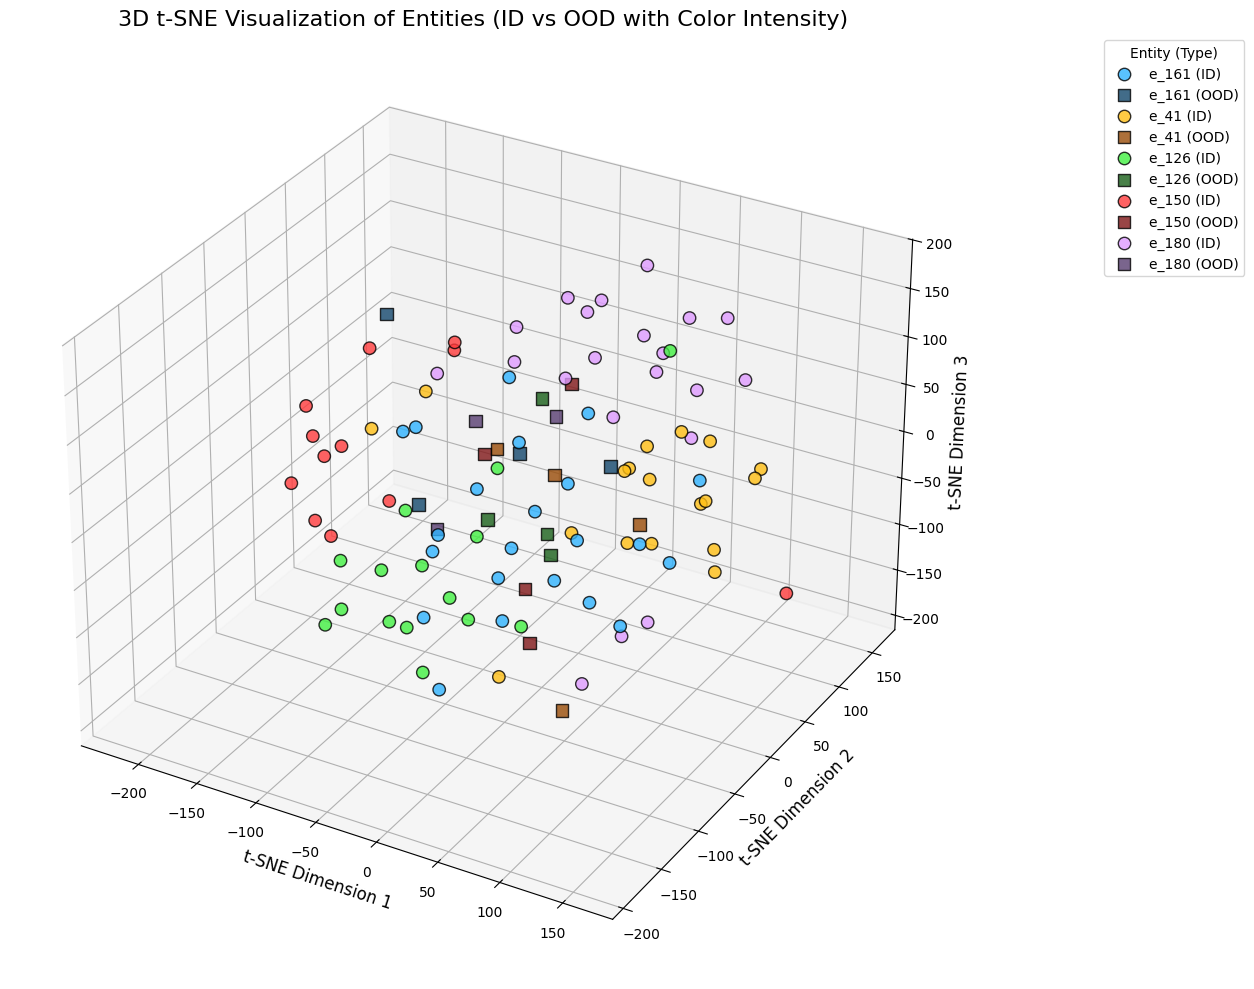

In [155]:
plot_tsne_entities_with_intensity_3d(ID_rep_list, OOD_rep_list, entity_names, n_entities_to_plot=5, perplexity=30)

In [156]:
entity_names = [s.strip("<>") for s in most_common_entities_list]
entity_names

['e_161', 'e_41', 'e_126', 'e_150', 'e_180', 'e_184']

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# -------------------------
# 📦 Sample inputs (Replace with actual data)
# -------------------------
# ID_rep and OOD_rep should be lists of arrays, each array corresponds to an entity.
# Example structure:
# ID_rep = [entity1_ID_embeddings, entity2_ID_embeddings, ..., entity6_ID_embeddings]
# OOD_rep = [entity1_OOD_embeddings, entity2_OOD_embeddings, ..., entity6_OOD_embeddings]



# Concatenate representations for t-SNE
#all_representations = np.vstack(ID_rep_list + OOD_rep_list)

all_representations = np.vstack([ID_rep_list, OOD_rep_list])  # Your data
#labels = ["b_ID" for _ in ID_rep_list[0]] + ["b_OOD" for _ in OOD_rep_list[0]]

# Create labels in the format "entity_ID" or "entity_OOD"
labels = [f"{entity}_ID" for entity in entity_names[0] for _ in range(len(ID_rep_list[entity_names.index(entity)]))] + \
        [f"{entity}_OOD" for entity in entity_names[0] for _ in range(len(OOD_rep_list[entity_names.index(entity)]))]

#labels = [f"{entity}_ID" for entity in entity_name[0] for _ in range(len(ID_rep_list[entity_names.index(entity)]))] + \
        #[f"{entity}_OOD" for entity in entity_names[0] for _ in range(len(OOD_rep_list[entity_names.index(entity)]))]
# -------------------------
# 🧪 t-SNE Parameters
# -------------------------
perplexity = 10
n_components = 3  # 3D visualization

tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
reduced_embeddings = tsne.fit_transform(all_representations)

# -------------------------
# 🎨 Visualization Settings
# -------------------------
colors = ["blue", "red", "green", "purple", "orange", "brown"]
markers = {"ID": "o", "OOD": "s"}  # Circle for ID, Square for OOD

entity_color_map = {entity: colors[i] for i, entity in enumerate(entity_names)}

# -------------------------
# 📊 Create 3D Plot
# -------------------------
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each entity-ID/OOD combination
for entity in entity_names:
    for data_type in ["ID", "OOD"]:
        indices = [i for i, label in enumerate(labels) if label == f"{entity}_{data_type}"]
        if indices:
            ax.scatter(
                reduced_embeddings[indices, 0],
                reduced_embeddings[indices, 1],
                reduced_embeddings[indices, 2],
                c=entity_color_map[entity],
                marker=markers[data_type],
                label=f"{entity} ({data_type})",
                alpha=0.7,
                edgecolors='k',
                s=80
            )

# -------------------------
# 📝 Plot aesthetics
# -------------------------
ax.set_title("3D t-SNE Visualization of Entities (ID vs OOD)", fontsize=16)
ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
ax.set_zlabel("t-SNE Dimension 3", fontsize=12)
ax.legend(title="Entity (Type)", bbox_to_anchor=(1.1, 1), loc='upper left')
plt.tight_layout()
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [ ]:
plot_tsne_entities_with_intensity(ID_rep_list, OOD_rep_list,entity_names, n_entities_to_plot=12, perplexity=20, n_components=3, figsize=(14, 10))

In [ ]:
plot_tsne_entities(ID_rep_list, OOD_rep_list,  n_entities_to_plot=3, perplexity=40, n_components=3)

In [ ]:

similarity = cosine_similarity(ID_rep_list[3],OOD_rep_list[3]) #)OOD_rep_list[0])
print("Mean similarity:", similarity.mean())

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
similarity = cosine_similarity(ID_rep_list[0],ID_rep_list[2]) #)OOD_rep_list[0])
print("Mean similarity:", similarity.mean())

In [ ]:
# 50 k
plot_tsne_entities_with_intensity_2d(ID_rep_list, OOD_rep_list, entity_names, n_entities_to_plot=6,perplexity=30)

In [ ]:
# case with 500 000 iterations
plot_tsne_entities_with_intensity_2d(ID_rep_list, OOD_rep_list, entity_names, n_entities_to_plot=6,perplexity=30)

In [ ]:
#case with 1'500 000 iterations
plot_tsne_entities_with_intensity_2d(ID_rep_list, OOD_rep_list, entity_names, n_entities_to_plot=6,perplexity=30)